# Features

Os features são localizações de imagens "fáceis" de encontrar no futuro. De fato, uma das primeiras técnicas de detecção de features Lucas-Kanade, às vezes chamada de Kanade-Lucas-Tomasi ou features KLT, vem de um artigo seminal chamado "Good features to track".

As edges encontram descontinuidades de brilho em uma imagem, as features encontram regiões distintas. Existem vários detectores de features diferentes e todos eles têm algumas características em comum: eles devem ser rápidos de encontrar, e as coisas que estão próximas no espaço da imagem estão próximas no espaço das features (isto é, a representação das features de um objeto parece como a representação de features de objetos que se parecem com aquele objeto).

Para mais detalhes você pode ler esse [conjunto de tutoriais](https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html) OpenCV.

Começaremos importando as bibliotecas necessárias para trabalharmos.

In [1]:
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 

Carregamos a imagem:

In [6]:
image = cv2.imread('imagens/crow.jpg')

Apresentamos a imagem:

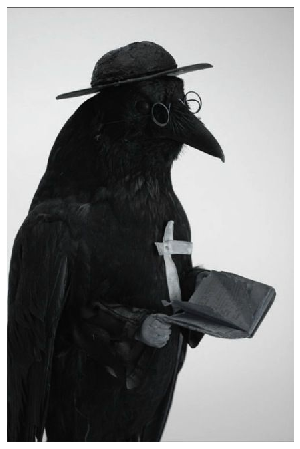

In [11]:
plt.figure(figsize=(11,8))
plt.imshow(image)
plt.axis('off');

## Detectores de Canto

Se você pensar nas edges como sendo linhas, então os cantos são uma escolha óbvia para features, pois representam a interseção de duas linhas. Um dos primeiros detectores de canto foi introduzido por Harris e ainda é um detector de canto muito eficaz, muito usado: é confiável e rápido.

Para saber mais detalhes sobre ele, você pode visitar a [documentação oficial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html) do OpenCV.

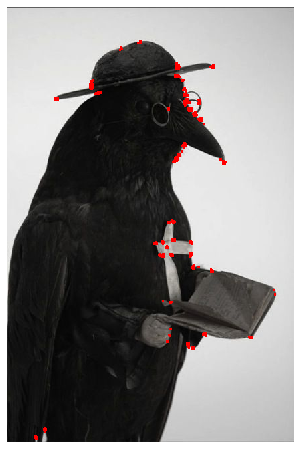

In [13]:
harris_test = image.copy()

gray = cv2.cvtColor(harris_test,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
blocksize = 4 # tamanho do bloco
kernel_size = 3 # sobel kernel: deve ser ímpar e pequeno

# rodamos o harris corner detector (detector de cantos)
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05)
dst = cv2.dilate(dst,None)

harris_test[dst > 0.01 * dst.max()] = [0,0,255]
plt.figure(figsize=(11,8))
plt.imshow(cv2.cvtColor(harris_test, cv2.COLOR_BGR2RGB));
plt.axis('off');

Falando corretamente, a detecção de Harris Corner é mais como um operador Sobel - na verdade, é muito parecido com um operador sobel. Na verdade, ele não retorna um conjunto de features; em vez disso, é um filtro que fornece uma resposta forte em regiões semelhantes a cantos da imagem.

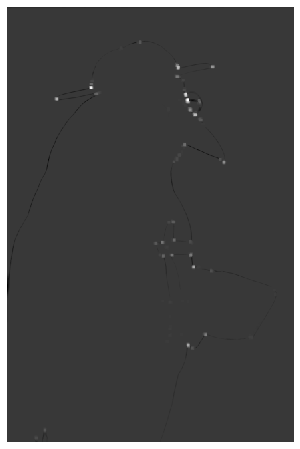

In [15]:
plt.figure(figsize=(11,8))
plt.imshow(dst,cmap = 'gray') 
plt.axis('off');

## Movendo-se em Direção ao Espaço de Features

Quando consideramos os detectores de features modernos, há alguns elementos que precisamos mencionar. O que torna um bom feature inclui o seguinte:

- Repetibilidade (preciso ser capaz de encontrá-lo novamente)
- Distintividade / informatividade (features que representam coisas diferentes precisam ser diferentes)
- Localidade (eles precisam ser locais para o elemento da imagem e não, como, a imagem inteira)
- Quantidade (você precisa ser capaz de encontrar o suficiente para que sejam adequadamente úteis)
- Precisão (eles precisam localizar com precisão o elemento da imagem)
- Eficiência (eles devem ser computáveis em um tempo razoável)

**Observação**: alguns dos mais famosos detectores de features (SIFT / SURF e assim por diante) existem, mas não estão no OpenCV por padrão devido a problemas de patente. Você pode construí-los para OpenCV se quiser - ou você pode encontrar outras implementações (a implementação SIFT de David Lowe funciona bem).

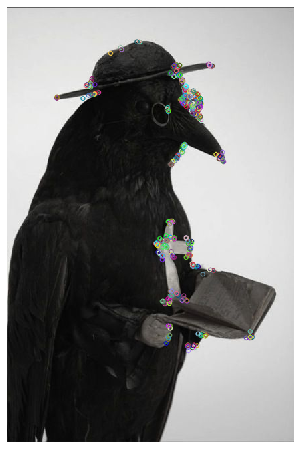

In [17]:
orbimg = image.copy()

orb = cv2.ORB_create()
# encontre os pontos chaves com ORB
kp = orb.detect(orbimg,None)
# computamos os descritores com ORB
kp, des = orb.compute(orbimg, kp)
# desenhamos os pontos chaves
cv2.drawKeypoints(orbimg,kp,orbimg)

plt.figure(figsize=(11,8))
plt.imshow(cv2.cvtColor(orbimg, cv2.COLOR_BGR2RGB))
plt.axis('off');

## Matching Features

Encontrar features é uma coisa, mas na verdade queremos usá-los para fazer a correspondência. 

Primeiro, vamos buscar algo onde sabemos que vai haver uma correspondência:

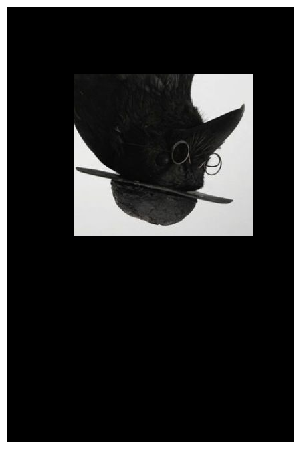

In [54]:
img_match = np.zeros(image.shape,np.uint8)

corvo = image[35:280, 70:340] 
img_match[60:250,70:350] = [0,0,0] 
corvo = cv2.flip(corvo,0) 
img_match[100:100+corvo.shape[0], 100:100+corvo.shape[1]] = corvo #
plt.figure(figsize=(11,8))
plt.imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
plt.axis('off');

## Matching Keypoints

A função de correspondência de features (neste caso, Orb) detecta e, a seguir, calcula os descritores de pontos-chave. Trata-se de uma representação de dimensão superior da região da imagem imediatamente em torno de um ponto de interesse (às vezes literalmente chamado de "pontos de interesse").

Essas representações de dimensões superiores podem então ser combinadas; a força que você ganha combinando esses descritores em vez de regiões de imagem diretamente é que eles têm uma certa invariância para transformações (como rotação ou dimensionamento). OpenCV fornece rotinas de correspondência para fazer isso, nas quais você pode especificar a medida de distância a ser usada.

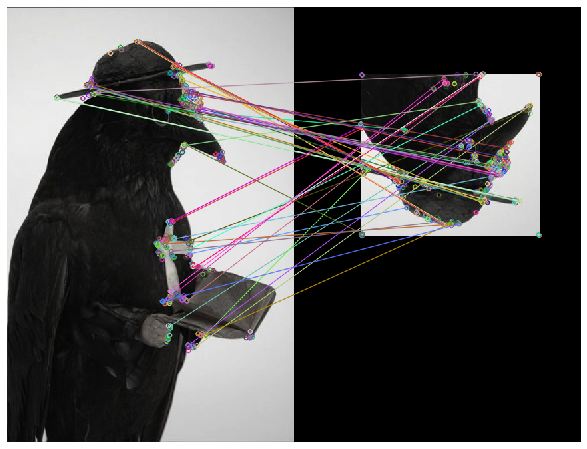

In [55]:
kp2 = orb.detect(img_match,None)

# computamos os descritores com ORB
kp2, des2 = orb.compute(img_match, kp2)

# criamos BFMatcher object: esse é um Brute Force matching object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# fazemos o matche dos descritores
matches = bf.match(des,des2)
 
# ordene-os pela distância entre as correspondências no espaço de feature - para que as melhores correspondências surjam primeiro.
matches = sorted(matches, key = lambda x:x.distance)
 
# desenhamos as 50 primeiras matches
oimg = cv2.drawMatches(orbimg,kp,img_match,kp2,matches[:50], orbimg)
plt.figure(figsize=(13,8))
plt.imshow(cv2.cvtColor(oimg, cv2.COLOR_BGR2RGB))
plt.axis('off');

Como podemos ver, existem algumas correspondências falsas, mas é bastante claro que a maioria dos pontos-chave correspondidos encontrados são correspondências reais entre as regiões da imagem na face do corvo.